# Business Understanding

<hr style="border: 2px solid black;">

### Overview of the dataset
The Lung & Colon Cancer Histopathological Images dataset comprised of microscopic images of healthy and cancerous human tissue. For this lab, I'll be focusing on the colon_image_sets in the subset of images, which contains color images of colon tissue slides. The images are labeled as normal or malignant adenocarcinoma, allowing a binary classification task. Images are stored as raw JPEGs with sizes around 768 x 768 pixels.

### Purpose of the dataset
The images were collected by pathologists to support diagnostics in oncology research. Histopathology, which is looking at tissue under a microscope, is the standard for clinical diagnosis of colon cancer, but reviewing it manually can be time-consuming and subject to human variability. By providing this dataset the researchers aimed to development benchmarking automated imaged-analysis to speed or aid in cancer detection.

### Prediction Task and interested third parties
The prediction task is to classify an image of colon tissue as normal or adenocarcinoma. 
Third parties that would benefit from these predictions could be:
- Pathology Labs and hospitals
- Medical Device Companies and diagnostic AI companies
- Public Health Researchers

### Importance of the data
Colon cancer is one of the most common cancers in the world, and an early detection greatly improves patient outcomes. Highly detailed and labeled images are needed for training algorithms that can highlight cancerous tissue accurately, potentially reducing diagnostic time and cost.

### Performance Expectations
In a clinical setting, a classification algorithm would need high sensitivity to avoid missing cancers while maintaining high specificity to limiting false positives. A useful model would need sensitivity/specificity factors to be at least above 90% - 95%, because even a small error could affect recommendations of patient care. For research purposes, maybe a slightly lower performance could be accepted as a second opinion to assist pathologist.


<hr style="border: 2px solid black;">     

Dataset Link: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

Borkowski, A. A., Bui, M. M., Thomas, L. B., Wilson, C. P., DeLand, L. A., & Mastorides, S. M. (2019). Lung and colon cancer histopathological image dataset (LC25000) (Version 1) [Preprint]. arXiv. https://arxiv.org/abs/1912.12142

## Data Preparation

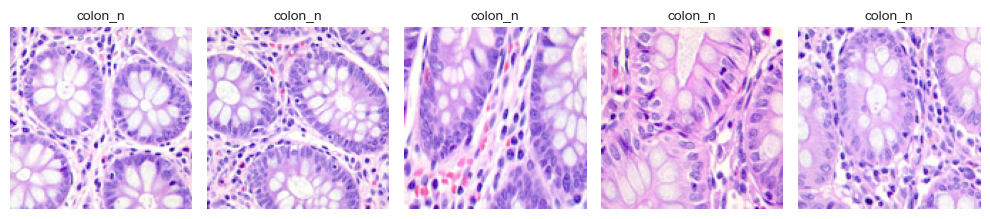

In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
data = "data/colon_image_sets"
image_size = [128, 128]

images = []
labels = []

# Load from filepath resize and covert images
for label_name in os.listdir(data):
    label_path = os.path.join(data, label_name)
    if not os.path.isdir(label_path):
        continue
    for filename in os.listdir(label_path):
        image_path = os.path.join(label_path, filename)
        try:
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                img = img.resize(image_size)
                images.append(np.array(img))
                labels.append(label_name)
        except Exception as e:
            print(f'Error: {e}')
        
# Covert to numpy arrays
images = np.array(images)
labels = np.array(labels)

x = images.reshape(images.shape[0], -1)

# Visualize 
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(ax):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [2]:
# Dataset specifics (https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb)
n_samples, n_features = x.shape
h, w = images.shape[1:3]
class_names = np.unique(labels)
n_classes = len(class_names)

print("Missing values:", np.sum(~np.isfinite(x)))
print(f"Number of samples: {n_samples}")
print(f"Number of flattened features per image: {n_features}")
print(f"Image dimensions: {h} x {w}")
print(f"Number of classes: {n_classes}")
print(f"Class names: {class_names}")
print("Feature vector size:", h * w * 3)

Missing values: 0
Number of samples: 10000
Number of flattened features per image: 49152
Image dimensions: 128 x 128
Number of classes: 2
Class names: ['colon_aca' 'colon_n']
Feature vector size: 49152


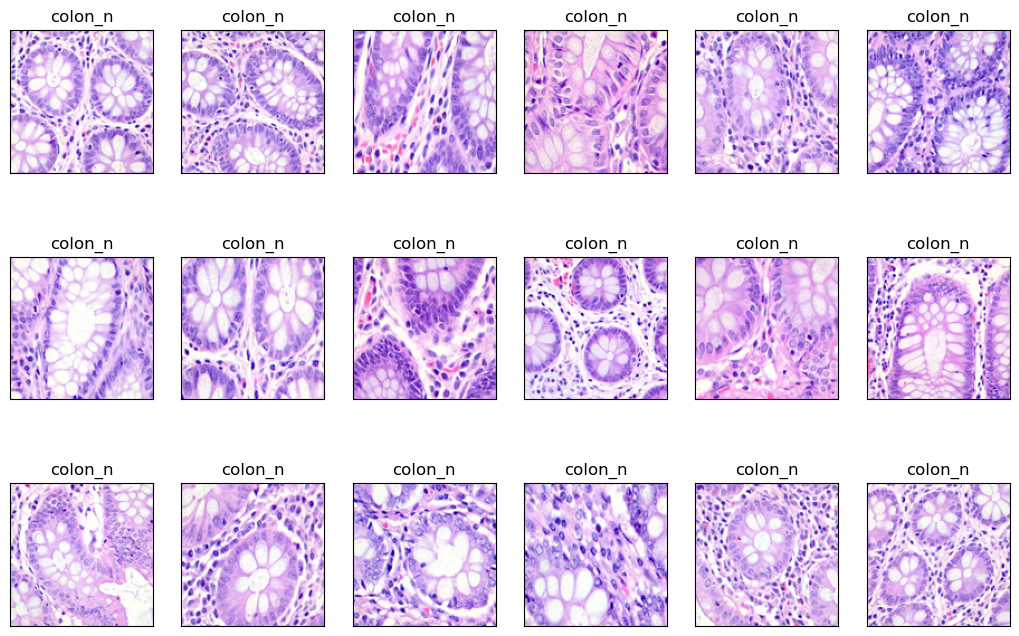

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(min(n_row * n_col, len(images))):  # avoid index error
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape(h, w, 3))  # RGB images
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

plot_gallery(images, labels, h=128, w=128, n_row=3, n_col=6)

# Data Reduction

## Linear dimensionality reduction using PCA

CPU times: user 8min 38s, sys: 1min 2s, total: 9min 41s
Wall time: 1min 1s


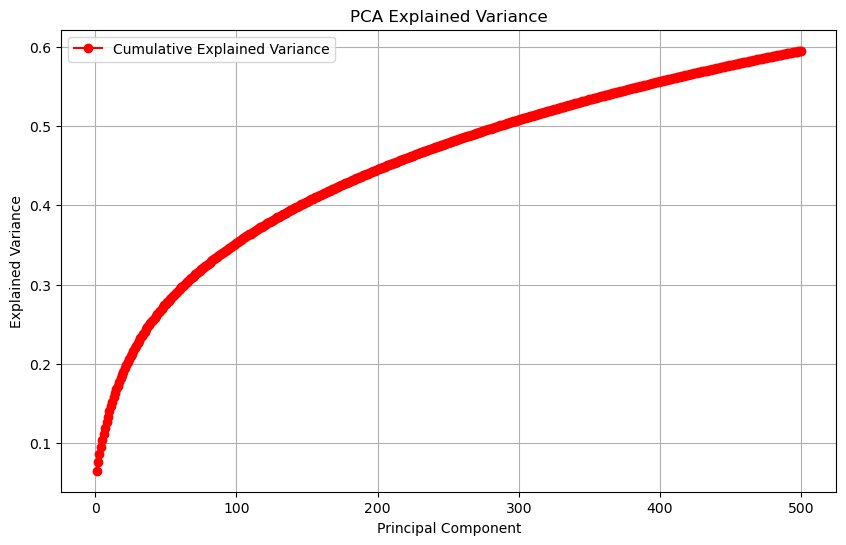

Number of components to capture 95% variance: 501


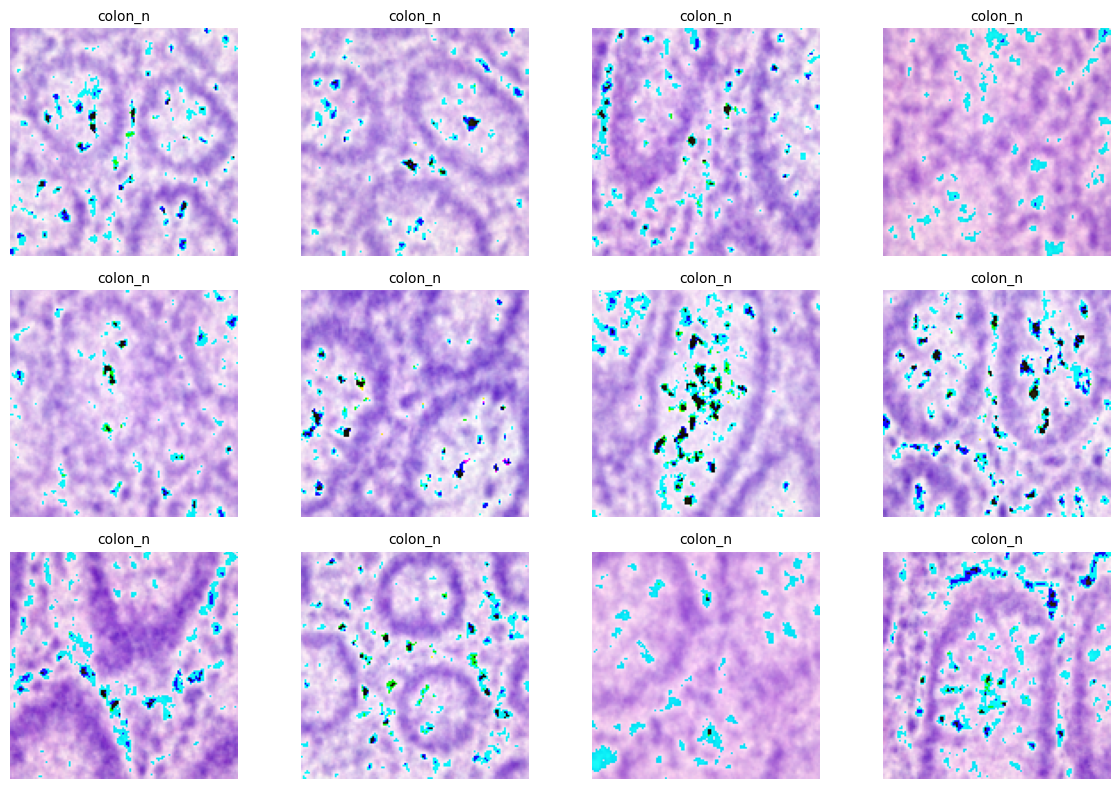

In [13]:
from sklearn.decomposition import PCA
import time

pca = PCA(n_components=500)
%time pca.fit(x.copy())

evr = pca.explained_variance_ratio_
cum_var = np.cumsum(evr)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(cum_var) + 1), cum_var,
         marker='o', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

n_95 = np.searchsorted(cum_var, 0.95) + 1
print(f"Number of components to capture 95% variance: {n_95}")

x_pca = pca.transform(x)               
x_reconstructed = pca.inverse_transform(x_pca) 
x_reconstructed_images = x_reconstructed.reshape(-1, h, w, 3)

# First 12 reconstructed images
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_reconstructed_images[i].astype(np.uint8))
    ax.set_title(labels[i], fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()



### Analysis of PCA Plot

The plot shows the cumulative explained variance as a function of the number of principal components in the images, and in this case, 501 components are needed to capture 95% of the variance in 500 components. However, in the scree plot the elbow of the curve looks to be around 50 - 100, meaning the colon images can be represented in 50 - 100 dimensions instead of the full raw pixels at 49152 vectors.

My conclusion is that reducing the data to more manageable dimensions will make other tasks such as feature extraction much faster while still preserving the structure and variation of the images. 

## Linear dimensionality reduction using Randomized PCA

CPU times: user 8min 3s, sys: 35 s, total: 8min 38s
Wall time: 47.1 s


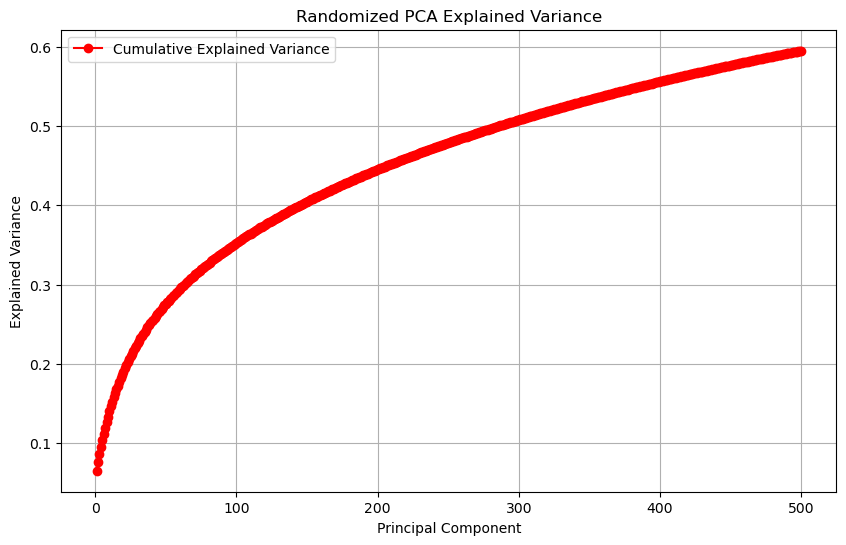

Number of components to capture 95% variance (Randomized PCA): 501


In [17]:
pca = PCA(n_components=500, svd_solver='randomized')
%time pca.fit(x.copy())

evr = pca.explained_variance_ratio_
cum_var = np.cumsum(evr)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(cum_var) + 1), cum_var,
         marker='o', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Randomized PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

n_95 = np.searchsorted(cum_var, 0.95) + 1
print(f"Number of components to capture 95% variance (Randomized PCA): {n_95}")

### Analysis of Randomized PCA Plot

The plot of the randomized PCA algorithm and the components variance to capture 95% of the data was the same as the standard PCA. One caveat was that the randomized version was a little faster with a Wall time: 47.1 s vs Wall time: 1min 1s. For this dataset there was 21.67% increase computation speed which means randomized PCA is 22% faster than standard PCA for this data.

### Quantitative Analysis

Standard PCA and Randomized PCA represented the data very well. The cumulative explained variance curves were nearly the same, and both methods required 501 components to capture 95% of the variance which means similar quality of representation. The main observed difference was computation speed. Given the similar data representation and the faster computation speed, my method choice for this dataset would be randomized PCA.

### Feature Extraction

In [18]:
from skimage.feature import hog
from skimage import color

# Convert to greyscale
gray_image = np.array([color.rgb2gray(img) for img in images])


# Extract features using HOG
hog_feature = []
for img in gray_image:
    features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=8, block_norm='L2-Hys')
    hog_feature.append(features)

hog_feature = np.array(hog_feature)
print('HOG feature vector size:', hog_feature.shape)

HOG feature vector size: (10000, 1568)


## Heatmap of average HOG classes

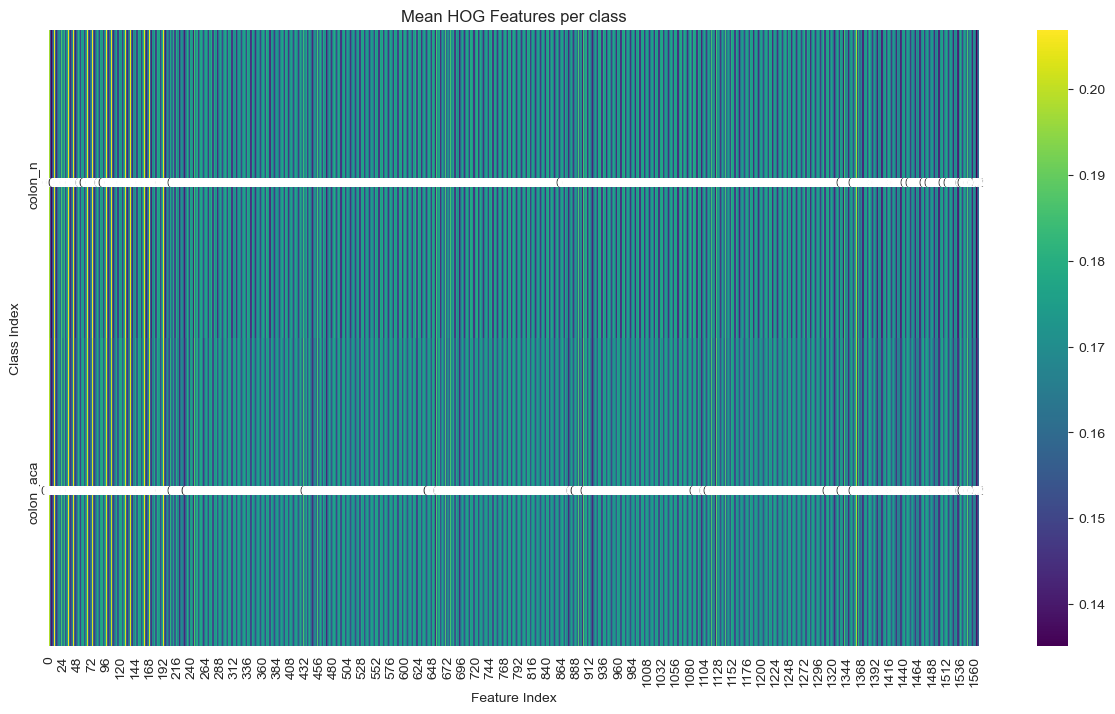

In [19]:
import seaborn as sns
import pandas as pd

classes = pd.unique(labels)

mean_features = np.array([hog_feature[labels == c].mean(axis=0) for c in classes])
df = pd.DataFrame(mean_features, index=classes)

plt.figure(figsize=(15,8))
sns.heatmap(df, annot=True, cmap='viridis')
plt.title('Mean HOG Features per class')
plt.xlabel('Feature Index')
plt.ylabel('Class Index')
plt.show()

## Nearest Neighbor Classification


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report

X_train, X_test, y_train, y_test = train_test_split(hog_feature, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy score:', accuracy_score(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

Accuracy score: 0.782
Classification report:               precision    recall  f1-score   support

   colon_aca       0.70      0.99      0.82       988
     colon_n       0.98      0.58      0.73      1012

    accuracy                           0.78      2000
   macro avg       0.84      0.78      0.77      2000
weighted avg       0.84      0.78      0.77      2000



## Feature extraction using DAISY Key Point Matching

In [13]:
from skimage.color import rgb2gray
from skimage.feature import daisy, corner_peaks

daisy_keypoints = [] # list of arrays per image
all_desc = []
for img in images:
    gray = rgb2gray(img)
    
    # Key points detection (limiting to first 100 key points)
    kps = corner_peaks(gray, min_distance=5, threshold_rel=0.1)[:100]
    
    # Remove keypoints close to image boarder
    margin = 15
    mask = (kps[:,0]>=margin) & (kps[:,1]<gray.shape[0]-margin) & (kps[:,1]>=margin & (kps[:,1]<gray.shape[1]-margin))
    kps = kps[mask]
    
    descriptor = daisy(gray, step=1, radius=15, rings=2, histograms=6, orientations=8)
    
    # map keypoints to DAISY grid
    kp_i = np.clip(np.round((kps[:,0]-15)/1).astype(int), 0, descriptor.shape[0]-1)
    kp_j = np.clip(np.round((kps[:,1]-15)/1).astype(int), 0, descriptor.shape[1]-1)
    
    kp_desc = descriptor[kp_i, kp_j, :]
    
    all_desc.append(kp_desc.astype('float32'))
    daisy_keypoints.append(len(kp_desc))

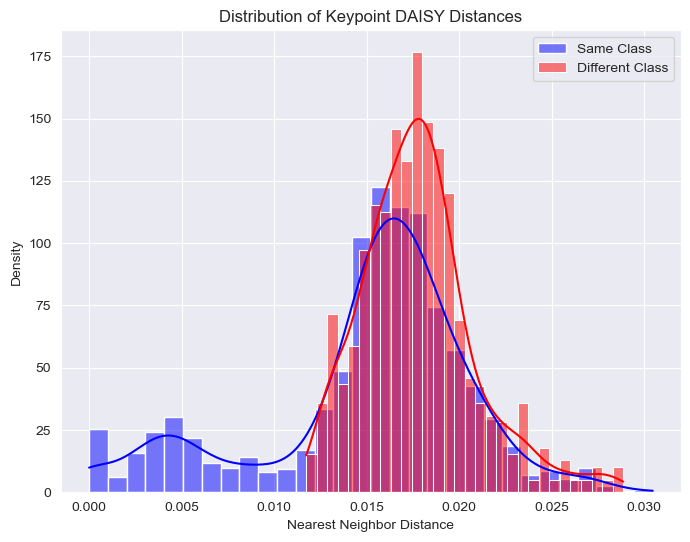

In [20]:
from annoy import AnnoyIndex
# Reference: https://medium.com/@kevin_yang/simple-approximate-nearest-neighbors-in-python-with-annoy-and-lmdb-e8a701baf905
stack_desc = np.vstack(all_desc)
desc_dim = stack_desc.shape[1]

# Build Annoy index
annoy_index = AnnoyIndex(desc_dim, 'euclidean')
for i, vec in enumerate(stack_desc):
    annoy_index.add_item(i, vec)
annoy_index.build(10)  # 10 trees


desc_labels = []
for i, n_kp in enumerate(daisy_keypoints):
    desc_labels.extend([labels[i]] * n_kp)
desc_labels = np.array(desc_labels)

distances_same = []
distances_diff = []

for i, vec in enumerate(stack_desc[:500]):
    nn_idxs, nn_dists = annoy_index.get_nns_by_item(i, 6, include_distances=True)
    for idx, dist in zip(nn_idxs[1:], nn_dists[1:]):
        if desc_labels[idx] == desc_labels[i]:
            distances_same.append(dist)
        else:
            distances_diff.append(dist)

plt.figure(figsize=(8,6))
sns.histplot(distances_same, color='blue', label='Same Class', kde=True, stat="density", bins=30)
sns.histplot(distances_diff, color='red', label='Different Class', kde=True, stat="density", bins=30)
plt.xlabel("Nearest Neighbor Distance")
plt.ylabel("Density")
plt.title("Distribution of Keypoint DAISY Distances")
plt.legend()
plt.show()


References: 

van der Walt, S., Schönberger, J. L., Nunez-Iglesias, J., Boulogne, F., Warner, J. D., Yager,            N., Gouillart, E., Yu, T. (2014). scikit-image: Image processing in Python. PeerJ, 2, e453.    https://doi.org/10.7717/peerj.453

eclarson. (n.d.). 04. Dimension Reduction and Images. MachineLearningNotebooks. GitHub. Retrieved September 27, 2025, from https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb

eclarson. (n.d.). ML_3a_pca.pdf. MachineLearningNotebooks. GitHub. Retrieved September 27, 2025, from https://github.com/eclarson/MachineLearningNotebooks/blob/master/PDF_Slides/current%20slides/ML_3a_pca.pdf

eclarson. (n.d.). ML_3b_daisy.pdf. MachineLearningNotebooks. GitHub. Retrieved September 27, 2025, from https://github.com/eclarson/MachineLearningNotebooks/blob/master/PDF_Slides/current%20slides/ML_3b_daisy.pdf

GeeksforGeeks. (2024, May 20). HOG feature visualization in Python using skimage. GeeksforGeeks. Retrieved September 27, 2025, from https://www.geeksforgeeks.org/machine-learning/hog-feature-visualization-in-python-using-skimage/

Yang, K. (2018, January 4). Simple approximate nearest neighbors in Python with Annoy and LMDB. Medium. https://medium.com/@kevin_yang/simple-approximate-nearest-neighbors-in-python-with-annoy-and-lmdb-e8a701baf905